In [1]:
from pathlib import Path

import pandas as pd

import matplotlib.pyplot as plt

from datetime import datetime as dt
from datetime import time

In [2]:
# This method takes in paramaters:
# 1) recover_folder: Name of the folder where the detections are stored.
# 2) audio_dur: The AudioMoth's configuration for the length of each recording.

# This method returns:
# - A DataFrame object that has columns:
#   - File Names, Date, Start Time, End Time, # of LF detections, # of HF detections
#   - File Names are strings and # of LF/HF detections are integers.
#   - Times are in UTC format and Dates are datetime.datetime objects.

def generate_df(recover_folder, audio_dur=pd.DateOffset(minutes=29, seconds=55)):

    # detection_dir is the recover-DATE-UNIT_NUM-detect folder where our detections are.
    detection_dir = f"detections/{recover_folder}"

    # Construct path object linked to the directory of files for datetime-parsing
    file_dir = Path(detection_dir)
    # We use this to only extract the original file names of the recordings.
    # The detection files will be assembled below.
    sorted_files = sorted(file_dir.glob('hf_*.txt'))

    # Create empty DataFrame object with all the required columns    
    df = pd.DataFrame(columns=["File Names", "Date", "Start Time (UTC)",
                       "End Time (UTC)", "# of LF detections", "# of HF detections"])
    
    # Iterate through all file paths to extract and store table information for each file
    for i, file in enumerate(sorted_files):
        # Extract name of each file as it is
        file_name = file.name
        # Extracting the datetime object from the name of each file
        file_info = dt.strptime(file_name, "hf_%Y%m%d_%H%M%S.WAV.txt")

        # Extract recording name, date, start time, and end time for each file
        recording_name = file_info.strftime("%Y%m%d_%H%M%S.WAV")
        date = file_info.date()
        s_time = file_info.time()
        e_time = (file_info+audio_dur).time()

        # Calling read_detection to return the table of selections as a dataframe
        # The detections appear twice: in waveform view and spectrogram view, 
        # so we half the total number of detections
        lf_file_detections = read_detection(detection_dir, recording_name, "lf")
        num_lf_detections = lf_file_detections.shape[0]/2
        hf_file_detections = read_detection(detection_dir, recording_name, 'hf')
        num_hf_detections = hf_file_detections.shape[0]/2
        
        # Add new row with the extracted information
        df.loc[len(df.index)] = [recording_name, date, s_time, e_time, num_lf_detections, num_hf_detections]
    
    return df

In [3]:
def generate_all_df_from_site(field_records, site_name):
    cond3 = field_records["Site"]==site_name
    df_site = field_records[cond3]
    dfs = []

    for index, row in df_site.iterrows():
        folder_name = row["Upload folder name"]
        sd_card = row["SD card #"]
        recover_folder = f"{folder_name}-{sd_card:03}-detect" 

        if (folder_name!="UPLOAD_FOLDER"):
            df = generate_df(recover_folder)
            dfs.append(df)

    return pd.concat(dfs)

In [4]:
# Given parameters:
# 1) detection_dir is the recover-DATE-UNIT_NUM-detect folder
# 2) recording_name is the name of our recording: DATE_TIME.WAV
# 4) det_type can either be 'lf' or 'hf'

# Output:
# The table of detections following the format of RavenPro

def read_detection(detection_dir, recording_name, det_type):
    
    file_name = f"{det_type}_{recording_name}.txt"
    file_path = f"{detection_dir}/{file_name}"
    
    if (Path(file_path).is_file()):
        df_detection = pd.read_csv(file_path, sep='\t')
    else:
        print(f"{file_path} is empty")
        df_detection = pd.DataFrame()
            
    return df_detection

In [47]:
def plot_separate(df, site, save=False):
    
    # To plot each day's activity separately, group by rows that have the same date
    # We need a list of unique dates from our detection files
    unique_dates = df["Date"].unique()
    
    # We plot for each date in our unique dates
    for date in unique_dates:
        day_df = df.loc[df['Date'] == date]
        
        day_df = pad_day_of_df(day_df, date)
        
        fig = day_df.plot.bar(x="Start Time (UTC)", figsize=(12, 4), fontsize=12, rot=60)
        fig.set_title(f"{date} in {site}", fontsize=14)
        fig.set_xticks(fig.get_xticks())
        fig.set_ylim([0, 1.1*max(df["# of LF detections"].max(), df["# of HF detections"].max())])
        
        # If the user wants to save, it goes into the below path
        if save:
            save_folder = f"../results/raven_energy_detector_raw/call_num_summary/{recover_folder}/FIGS"
            save_dir = Path(save_folder)
            save_dir.mkdir(parents=True, exist_ok=True)
            save_path = Path(f"{save_folder}/{date}.png")
            fig.get_figure().savefig(save_path, facecolor='w', bbox_inches = "tight")

In [48]:
def plot_total(df, site, save=False):
    
    # To plot each day's activity separately, group by rows that have the same date
    # We need a list of unique dates from our detection files
    unique_dates = df["Date"].unique()
    
    fig = df.plot.bar(x="Start Time (UTC)", figsize=(12, 4), fontsize=12, rot=60)
    fig.set_title(f"Activity from {unique_dates[0]} to {unique_dates[-1]} in {site}", fontsize=14)
    fig.set_xticks(fig.get_xticks()[::len(unique_dates)])
    fig.set_ylim([0, 1.1*max(df["# of LF detections"].max(), df["# of HF detections"].max())])
    print(max(df["# of LF detections"].max(), df["# of HF detections"].max()))
    
    # If the user wants to save, it goes into the below path
    if save:
        save_folder = f"../results/raven_energy_detector_raw/call_num_summary/{site}"
        save_dir = Path(save_folder)
        save_dir.mkdir(parents=True, exist_ok=True)
        save_path = Path(f"{save_folder}/activity.png")
        fig.get_figure().savefig(save_path, facecolor='w', bbox_inches = "tight")

In [49]:
def get_field_records():
    path_to_records = Path(f"ubna_2022b.csv")

    if (path_to_records.is_file()):
        fr = pd.read_csv(path_to_records, sep=',') 

    return fr

In [50]:
def get_site_name(fr, DATE, SD_CARD_NUM):
    cond1 = fr["Upload folder name"]==f"recover-{DATE}"
    cond2 =  fr["SD card #"]==int(SD_CARD_NUM)
    site = fr.loc[cond1&cond2, "Site"]
    
    if (site.empty):
        site_name = "(Site not found in Field Records)"
    else:
        site_name = site.item()
    
    return site_name

In [51]:
def pad_day_of_df(day_df, date):
    
    # Create empty DataFrame object with all the required columns    
    left_pad_df = pd.DataFrame(columns=["File Names", "Date", "Start Time (UTC)",
                   "End Time (UTC)", "# of LF detections", "# of HF detections"])
    
    # Create empty DataFrame object with all the required columns    
    right_pad_df = pd.DataFrame(columns=["File Names", "Date", "Start Time (UTC)",
                   "End Time (UTC)", "# of LF detections", "# of HF detections"])

    # This section builds a dataframe of empty values from 0:00 to the first time of the recordings.
    # This way we can make each plot comparable on the left edge.
    # We insert this dataframe in the beginning of day_df.
    s_time = day_df["Start Time (UTC)"].iloc[0]
    st_row = time(0, 0, 0)
    while (st_row < s_time):
        file_info = dt.combine(date, st_row)
        recording_name = file_info.strftime("%Y%m%d_%H%M%S.WAV")
        e_time = (file_info+pd.DateOffset(minutes=29, seconds=55)).time()
        left_pad_df.loc[len(left_pad_df.index)] = [recording_name, date, st_row, e_time, None, None]
        st_row = (file_info+pd.DateOffset(minutes=30)).time()
    
    day_df = pd.concat([left_pad_df, day_df])
    
    # This section builds a dataframe of empty values from the end time of the recordings to 24:00.
    # This way we can make each plot comparable on the right edge.
    # We insert this dataframe at the end of day_df.
    st_row = day_df["Start Time (UTC)"].iloc[-1]
    e_time = time(23, 30, 0)
    while (st_row < e_time):
        file_info = dt.combine(date, st_row)
        recording_name = file_info.strftime("%Y%m%d_%H%M%S.WAV")
        et_row = (file_info+pd.DateOffset(minutes=29, seconds=55)).time()
        st_row = (file_info+pd.DateOffset(minutes=30)).time()
        right_pad_df.loc[len(right_pad_df.index)] = [recording_name, date, st_row, et_row, None, None]
        
    day_df = pd.concat([day_df, right_pad_df])
    
    return day_df

In [102]:
# These are constants that we absolutely need to know before running any scripts

# Constant DATE is the date of our recovered data that we are extracting detections from
DATE = "20220811"
# Constant SD_CARD_NUM is the SD CARD # that had been deployed for that session
SD_CARD_NUM = "010"

field_records = get_field_records()
site_name = get_site_name(field_records, DATE, SD_CARD_NUM)

In [103]:
recover_folder = f"recover-{DATE}-{SD_CARD_NUM}-detect"
df = generate_df(recover_folder)
df

,File Names,Date,Start Time (UTC),End Time (UTC),# of LF detections,# of HF detections
0,20220808_174504.WAV,2022-08-08,17:45:04,18:14:59,0.0,2.0
1,20220808_180000.WAV,2022-08-08,18:00:00,18:29:55,0.0,0.0
2,20220808_183000.WAV,2022-08-08,18:30:00,18:59:55,0.0,0.0
3,20220808_190000.WAV,2022-08-08,19:00:00,19:29:55,0.0,0.0
4,20220808_193000.WAV,2022-08-08,19:30:00,19:59:55,0.0,0.0
...,...,...,...,...,...,...
153,20220811_220000.WAV,2022-08-11,22:00:00,22:29:55,0.0,0.0
154,20220811_223000.WAV,2022-08-11,22:30:00,22:59:55,1.0,0.0
155,20220811_230000.WAV,2022-08-11,23:00:00,23:29:55,1.0,0.0
156,20220811_233000.WAV,2022-08-11,23:30:00,23:59:55,3.0,0.0


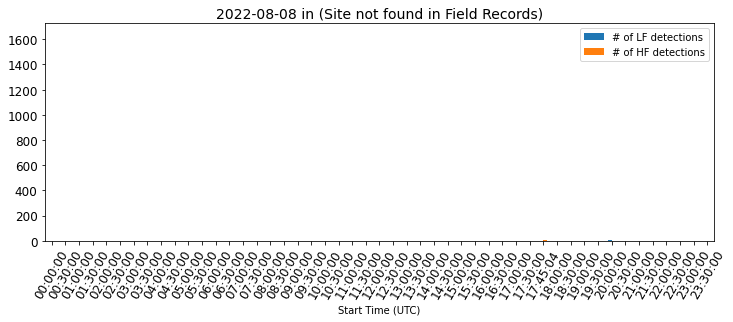

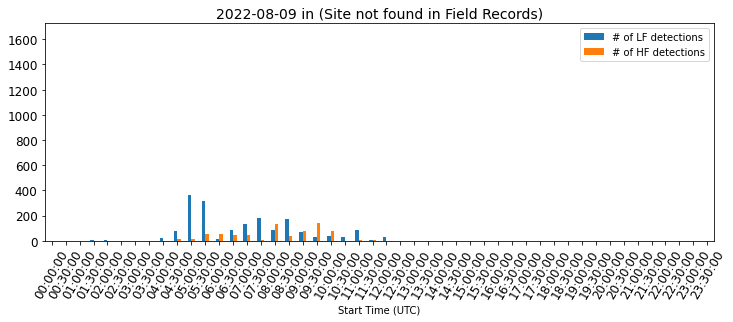

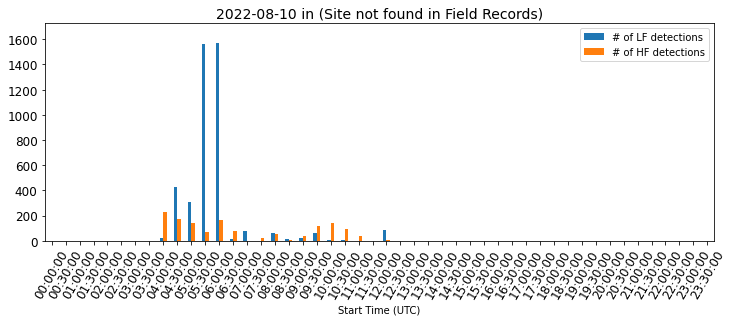

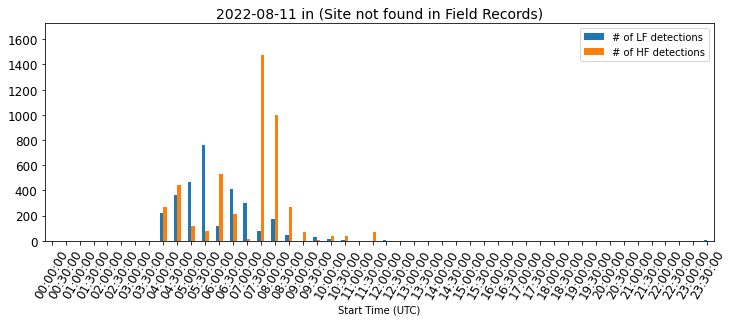

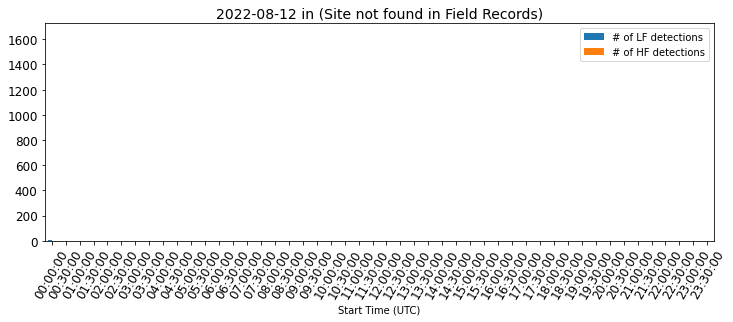

In [104]:
plot_separate(df, site_name, save=True)

1570.0


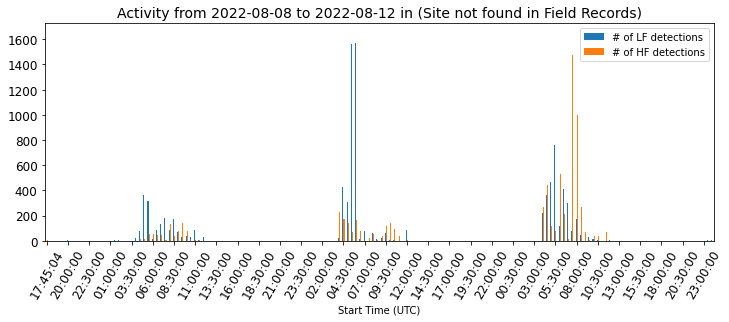

In [105]:
plot_total(df, site_name)

In [98]:
df_all = generate_all_df_from_site(field_records, site_name)

detections/recover-20220804-001-detect/lf_20220804_230000.WAV.txt is empty


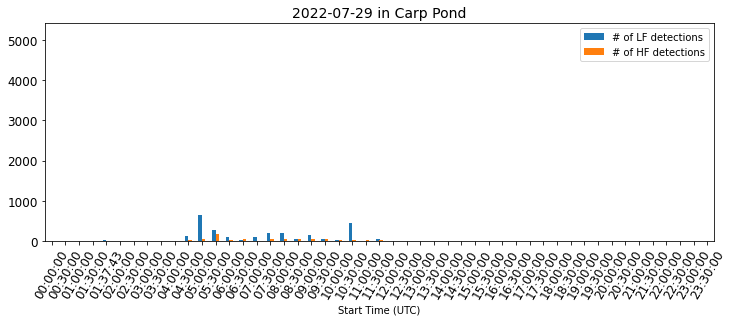

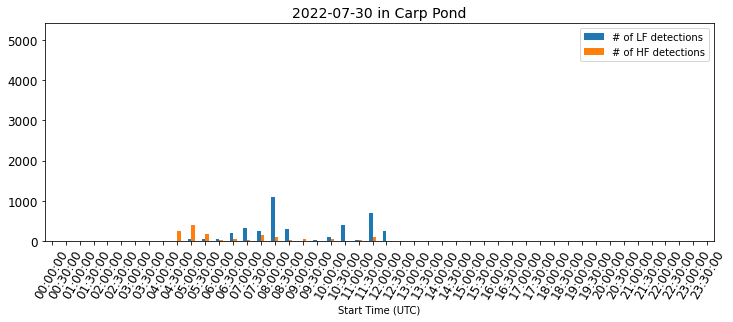

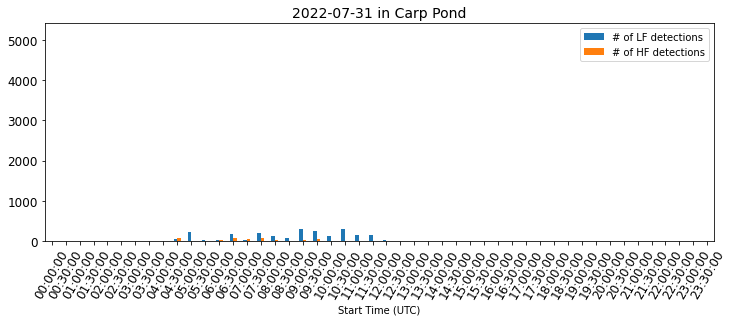

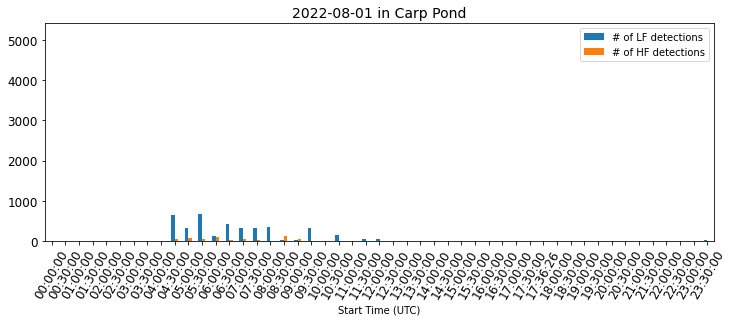

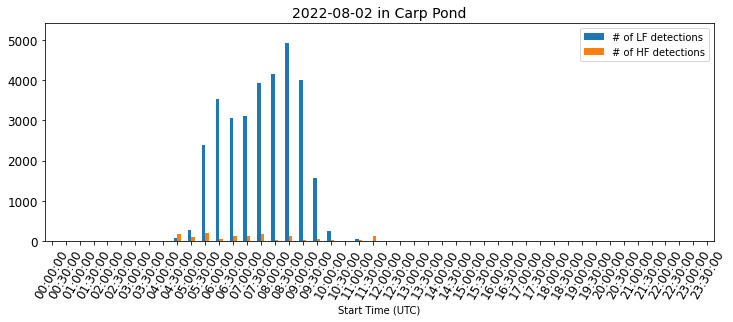

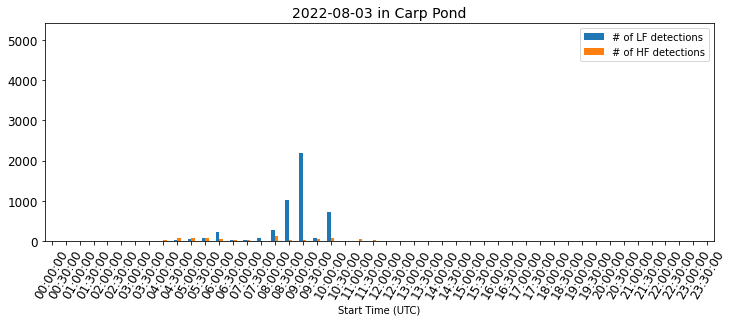

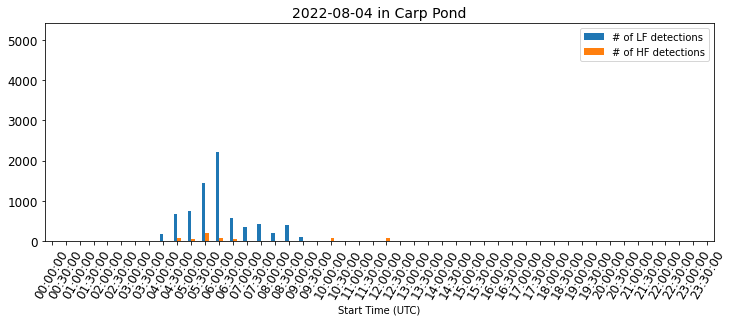

In [99]:
plot_separate(df_all, site_name, save=False)

In [17]:
# detection_dir is the recover-DATE-UNIT_NUM-detect folder where our detections are.
detection_dir = f"detections/{recover_folder}"

# Construct path object linked to the directory of files for datetime-parsing
file_dir = Path(detection_dir)
# We use this to only extract the original file names of the recordings.
# The detection files will be assembled below.
sorted_files = sorted(file_dir.glob('hf_*.txt'))

# Create empty DataFrame object with all the required columns    
df = pd.DataFrame(columns=["Start - End (UTC)"])
time_row = time()

# Iterate through all file paths to extract and store table information for each file
for i in range(48):
    
    # Extracting the datetime object from the name of each file
    file_info = dt.combine(dt.now(), time_row)
    time_row = (file_info+pd.DateOffset(minutes=30)).time()
    
    s_time = file_info.time()
    e_time = (file_info+pd.DateOffset(minutes=29, seconds=55)).time()
    
    # Add new row with the extracted information
    df.loc[len(df.index)] = [f"{s_time} - {e_time}"]

df

,Start - End (UTC)
0,00:00:00 - 00:29:55
1,00:30:00 - 00:59:55
2,01:00:00 - 01:29:55
3,01:30:00 - 01:59:55
4,02:00:00 - 02:29:55
5,02:30:00 - 02:59:55
6,03:00:00 - 03:29:55
7,03:30:00 - 03:59:55
8,04:00:00 - 04:29:55
9,04:30:00 - 04:59:55
